In [25]:
import csv

def load_dataset(file_path, has_header=True):
    data = []
    with open(file_path, "r") as f:
        reader = csv.reader(f)
        #if has_header:
        #   next(reader)  # skip header row if there's any header
        for row in reader:
            vector = [float(val) for val in row]  # convert all values to float
            data.append(vector)
    return data

# My dataset path in Colab Notebook
file_path = "Dataset2.csv"

points = load_dataset(file_path, has_header=True)

print("First 5 points:", points[:5])


First 5 points: [[0.143, 0.98493], [-0.30467, 0.98562], [0.46625, -0.84003], [0.94847, 0.37222], [-0.96871, -0.26697]]


In [26]:
num_rows = len(points)          # number of data points
num_cols = len(points[0])       # number of dimensions per point

print("Shape:", (num_rows, num_cols))


Shape: (1000, 2)


## often seen the dataset in d*n dimension:

In [27]:
def transpose(data):
    return [list(row) for row in zip(*data)]

points_T = transpose(points)

# Now points_T is d × n
print("Original shape (n × d):", (len(points), len(points[0])))
print("Transposed shape (d × n):", (len(points_T), len(points_T[0])))


Original shape (n × d): (1000, 2)
Transposed shape (d × n): (2, 1000)


### Calculating for the PCA from here

In [28]:
# First dimension is points_T[0]
first_dim = points_T[0]

# Mean of first dimension
mean_first_dim = sum(first_dim) / len(first_dim)

print("Mean of first dimension:", mean_first_dim)


Mean of first dimension: 4.0749999999853835e-07


In [29]:
second_dim = points_T[1]

mean_second_dim = sum(second_dim)/len(second_dim)

print("Mean of second dimension:",mean_second_dim)

Mean of second dimension: 2.2269999999216095e-07


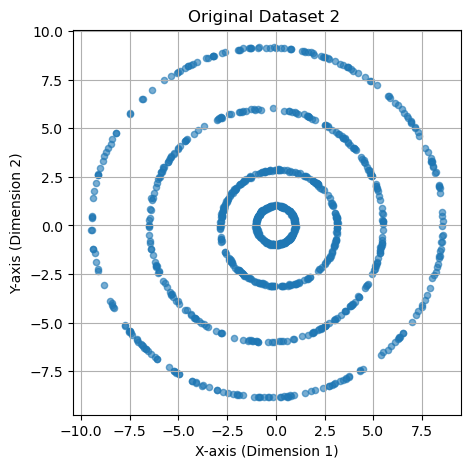

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Convert to numpy array
X = np.array(points)   # shape (1000, 2)

# Plot original dataset
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], alpha=0.6, s=20)
plt.xlabel("X-axis (Dimension 1)")
plt.ylabel("Y-axis (Dimension 2)")
plt.title("Original Dataset 2 ")
plt.grid(True)
plt.show()


In [31]:
import numpy as np

# Assuming your dataset is stored as numpy array "points"
# shape: (n_samples, 2)
points = np.array(points, dtype=float)  # if not already numpy

# ---- Random initialization of 4 centroids ----
np.random.seed(0)   # fixed seed for reproducibility of first run
init_idx = np.random.choice(points.shape[0], size=4, replace=False)
centroids = points[init_idx]

print("Initial centroids (Run 1):")
print(centroids)


Initial centroids (Run 1):
[[ 5.8058   6.6414 ]
 [-3.5859   8.6044 ]
 [-2.8491   0.17697]
 [ 5.1397   2.0418 ]]


### Q2_p1

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Helper functions (same as before) ----------

def assign_clusters(points, centroids):
    distances = np.sqrt(((points[:, None, :] - centroids[None, :, :]) ** 2).sum(axis=2))
    labels = np.argmin(distances, axis=1)
    clusters = [points[labels == i] for i in range(centroids.shape[0])]
    return labels, clusters

def compute_centroids(clusters, points, labels, k):
    centroids = np.zeros((k, points.shape[1]))
    for i in range(k):
        pts = points[labels == i]
        if len(pts) > 0:
            centroids[i] = pts.mean(axis=0)
        else:
            centroids[i] = points[np.random.randint(0, len(points))]
    return centroids

def compute_error(points, centroids, labels):
    diffs = points - centroids[labels]
    return (diffs**2).sum()

def kmeans(points, k=4, max_iters=100, tol=1e-6, seed=None):
    np.random.seed(seed)
    init_idx = np.random.choice(points.shape[0], size=k, replace=False)
    centroids = points[init_idx]

    errors = []
    for _ in range(max_iters):
        labels, clusters = assign_clusters(points, centroids)
        error = compute_error(points, centroids, labels)
        errors.append(error)

        new_centroids = compute_centroids(clusters, points, labels, k)

        if np.allclose(centroids, new_centroids, atol=tol):
            break
        centroids = new_centroids

    return centroids, labels, clusters, errors

### Plotting varnoi regions and the error functions

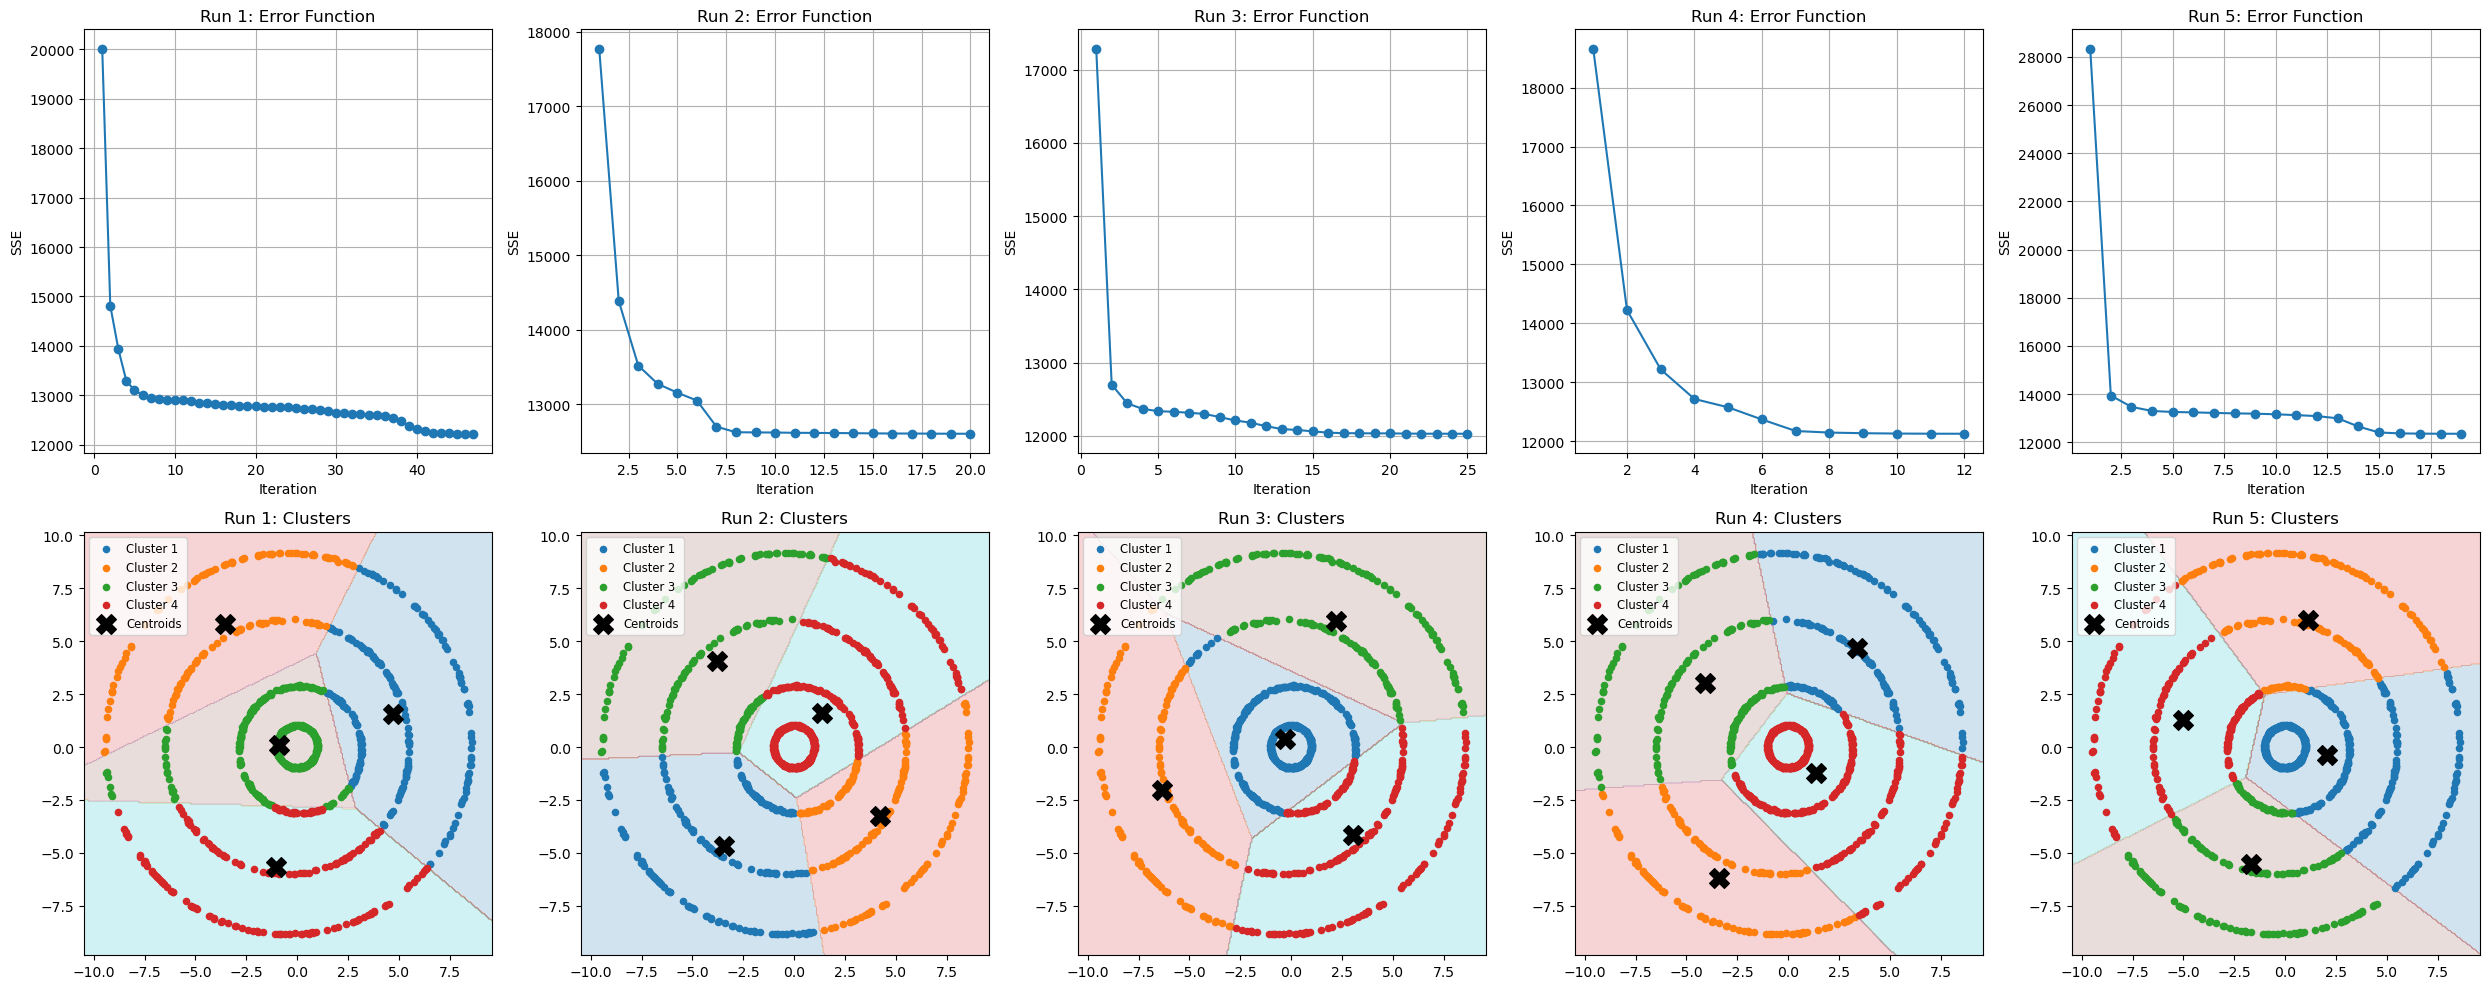

In [33]:
# ---------- Plotting function (one error + one cluster) ----------

def plot_run(points, centroids, labels, errors, run_idx, ax_err, ax_cluster):
    k = centroids.shape[0]

    # Error curve
    ax_err.plot(range(1, len(errors)+1), errors, marker="o")
    ax_err.set_title(f"Run {run_idx}: Error Function")
    ax_err.set_xlabel("Iteration")
    ax_err.set_ylabel("SSE")
    ax_err.grid(True)

    # Voronoi shading
    x_min, x_max = points[:,0].min()-1, points[:,0].max()+1
    y_min, y_max = points[:,1].min()-1, points[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    distances = np.sqrt(((grid[:, None, :] - centroids[None, :, :]) ** 2).sum(axis=2))
    vor_labels = np.argmin(distances, axis=1).reshape(xx.shape)

    ax_cluster.contourf(xx, yy, vor_labels, alpha=0.2, cmap="tab10")
    for i in range(k):
        pts = points[labels == i]
        ax_cluster.scatter(pts[:,0], pts[:,1], s=20, label=f"Cluster {i+1}")
    ax_cluster.scatter(centroids[:,0], centroids[:,1], c="black", marker="X", s=200, label="Centroids")
    ax_cluster.set_title(f"Run {run_idx}: Clusters")
    ax_cluster.legend(fontsize="small")


# ---------- Run KMeans 5 times & plot in 2 rows (errors top, clusters bottom) ----------

fig, axes = plt.subplots(2, 5, figsize=(25, 10))  # 2 rows, 5 columns

for run in range(5):
    centroids, labels, clusters, errors = kmeans(points, k=4, seed=run)
    plot_run(points, centroids, labels, errors, run+1, axes[0, run], axes[1, run])

plt.tight_layout()
plt.savefig("kmeans_5runs.png", dpi=300, bbox_inches='tight')
plt.show()


Q2_part_2

In [35]:

import numpy as np
import matplotlib.pyplot as plt

# ---------- KMeans (same helper functions as before) ----------
def assign_clusters(points, centroids):
    distances = np.sqrt(((points[:, None, :] - centroids[None, :, :]) ** 2).sum(axis=2))
    labels = np.argmin(distances, axis=1)
    clusters = [points[labels == i] for i in range(centroids.shape[0])]
    return labels, clusters

def compute_centroids(clusters, points, labels, k):
    centroids = np.zeros((k, points.shape[1]))
    for i in range(k):
        pts = points[labels == i]
        if len(pts) > 0:
            centroids[i] = pts.mean(axis=0)
        else:
            centroids[i] = points[np.random.randint(0, len(points))]
    return centroids

def compute_error(points, centroids, labels):
    diffs = points - centroids[labels]
    return (diffs**2).sum()

def kmeans(points, k=4, max_iters=100, tol=1e-6, seed=None):
    np.random.seed(seed)
    init_idx = np.random.choice(points.shape[0], size=k, replace=False)
    centroids = points[init_idx]

    for _ in range(max_iters):
        labels, clusters = assign_clusters(points, centroids)
        new_centroids = compute_centroids(clusters, points, labels, k)

        if np.allclose(centroids, new_centroids, atol=tol):
            break
        centroids = new_centroids

    return centroids, labels

In [36]:
# ---------- Plotting function ----------
def plot_voronoi(points, centroids, labels, ax, K):
    # Mesh grid based on dataset min/max
    x_min, x_max = points[:,0].min()-1, points[:,0].max()+1
    y_min, y_max = points[:,1].min()-1, points[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Assign grid to nearest centroid
    distances = np.sqrt(((grid[:, None, :] - centroids[None, :, :])**2).sum(axis=2))
    vor_labels = np.argmin(distances, axis=1).reshape(xx.shape)

    # Plot Voronoi background
    ax.contourf(xx, yy, vor_labels, alpha=0.2, cmap="tab10")

    # Plot clusters
    for i in range(K):
        pts = points[labels == i]
        ax.scatter(pts[:,0], pts[:,1], s=20, label=f"Cluster {i+1}")
    ax.scatter(centroids[:,0], centroids[:,1], c="black", marker="X", s=200, label="Centroids")
    ax.set_title(f"K = {K}")
    ax.legend(fontsize="small")

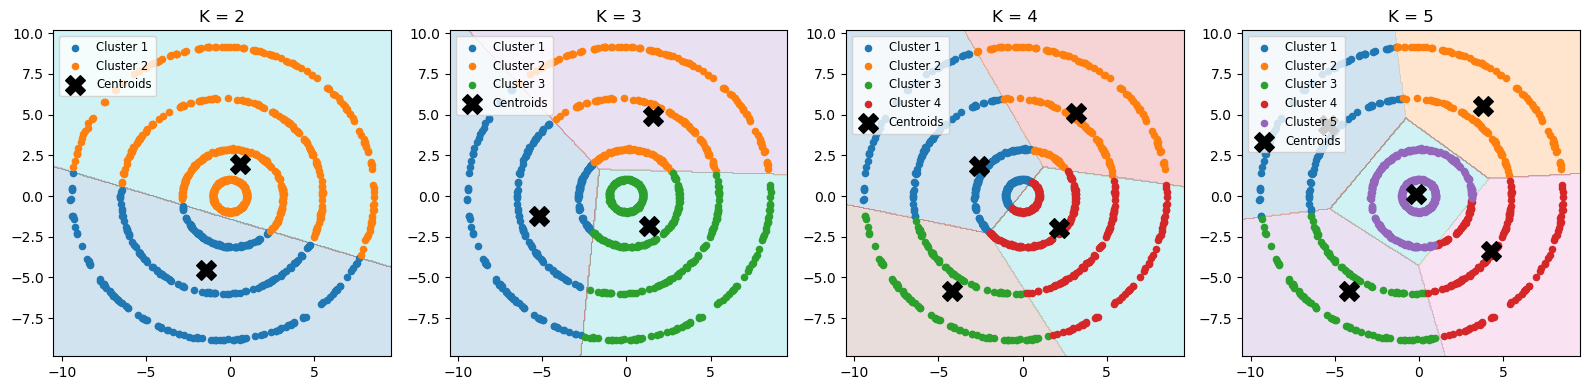

In [37]:
# ---------- Run for K = 2,3,4,5 ----------
fig, axes = plt.subplots(1, 4, figsize=(16, 4))  # 1 row, 4 plots

for idx, K in enumerate([2, 3, 4, 5]):
    centroids, labels = kmeans(points, k=K, seed=42)  # fixed seed for reproducibility
    plot_voronoi(points, centroids, labels, axes[idx], K)

plt.tight_layout()
plt.savefig("kmeans_voronoi.png", dpi=300, bbox_inches='tight')
plt.show()


Q2_P3 Spectral clustering in polynomial kernel

In [14]:
# Polynomial kernel (from scratch) + centering + eigendecomposition (only np.linalg.eigh used)
import numpy as np
import math
from typing import List, Tuple, Dict

def polynomial_kernel_from_scratch(points, degree=3, coef0=1.0, top_k=4, eps=1e-12):
    """
    Compute polynomial kernel matrix K_ij = (x_i . x_j + coef0)^degree using pure Python loops,
    center it in feature space (Kc), and return top_k eigenvectors/values (descending).

    Returns a dict with:
      - 'K'   : list of lists (raw polynomial kernel, symmetric)
      - 'Kc'  : centered kernel as a NumPy array (n x n)
      - 'eigvals_desc' : 1D NumPy array of eigenvalues sorted descending
      - 'eigvecs_desc' : 2D NumPy array columns are eigenvectors corresponding to eigvals_desc
      - 'U'   : embedding (n x top_k) = eigenvectors[:, :top_k] * sqrt(eigvals[:top_k])
    """
    # Accept points as list-of-lists or numpy array
    if hasattr(points, "tolist"):
        pts = [list(p) for p in points.tolist()]
    else:
        pts = [list(p) for p in points]

    n = len(pts)
    if n == 0:
        raise ValueError("points is empty")
    dim = len(pts[0])

    # Compute symmetric polynomial kernel K (pure python loops)
    K: List[List[float]] = [[0.0]*n for _ in range(n)]
    for i in range(n):
        xi = pts[i]
        for j in range(i, n):
            xj = pts[j]
            # compute dot product xi . xj
            dot = 0.0
            for d in range(dim):
                dot += xi[d] * xj[d]
            val = (dot + coef0) ** degree
            K[i][j] = val
            K[j][i] = val  # symmetry

    # Center the kernel: Kc = K - 1_n K - K 1_n + 1_n K 1_n
    # Compute row means and grand mean with loops
    row_sums = [0.0]*n
    for i in range(n):
        s = 0.0
        row_i = K[i]
        for j in range(n):
            s += row_i[j]
        row_sums[i] = s
    total_sum = sum(row_sums)
    row_means = [rs / n for rs in row_sums]
    col_means = [0.0]*n
    # columns: because K is symmetric col_means == row_means, but compute explicitly to be clear
    for j in range(n):
        s = 0.0
        for i in range(n):
            s += K[i][j]
        col_means[j] = s / n
    grand_mean = total_sum / (n*n)

    # form centered kernel Kc as NumPy array (ready for eig)
    Kc = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(n):
            Kc[i, j] = K[i][j] - row_means[i] - col_means[j] + grand_mean

    # Symmetrize numeric noise
    Kc = 0.5 * (Kc + Kc.T)

    # Eigen-decomposition (allowed library call)
    eigvals, eigvecs = np.linalg.eigh(Kc)   # eigh returns ascending eigenvalues

    # sort descending
    idx_desc = np.argsort(eigvals)[::-1]
    eigvals_desc = eigvals[idx_desc]
    eigvecs_desc = eigvecs[:, idx_desc]

    # take top_k components, clip small negatives and build kernel-PCA embedding U
    k_take = min(top_k, n)
    top_vals = eigvals_desc[:k_take].copy()
    top_vals = np.where(top_vals < 0, 0.0, top_vals)   # numeric safety
    top_vecs = eigvecs_desc[:, :k_take].copy()
    # embedding: scale eigenvectors by sqrt(eigenvalue) (kernel PCA coordinates)
    sqrt_vals = np.sqrt(top_vals + eps)   # avoid sqrt(0)
    U = top_vecs * sqrt_vals[np.newaxis, :]   # broadcasting via numpy on small arrays

    return {
        'K': K,
        'Kc': Kc,
        'eigvals_desc': eigvals_desc,
        'eigvecs_desc': eigvecs_desc,
        'U': U
    }

# ---------------- USAGE EXAMPLE ----------------
# Use your existing 'points' variable (list-of-lists or numpy array)
# Example: compute degree=3 polynomial kernel and top-4 components
res = polynomial_kernel_from_scratch(points, degree=3, coef0=1.0, top_k=4)
print("Top 4 eigenvalues (desc):", res['eigvals_desc'][:4])
U = res['U']   # embedding (n x 4) as NumPy array (safe to pass to k-means next)


Top 4 eigenvalues (desc): [61848666.65217691 48463583.71874344 19217324.02175849 16400455.05153178]


In [15]:
import random
import math

def kmeans_from_scratch(U, k=4, max_iters=100, seed=42):
    """
    Run K-means clustering on embedding U (n x d) using pure Python loops.
    Returns:
      - centroids: list of length k, each a list of d floats
      - labels: list of length n with cluster indices [0..k-1]
    """
    random.seed(seed)
    n = len(U)
    d = len(U[0])

    # --- Step 1: initialize centroids randomly ---
    init_indices = random.sample(range(n), k)
    centroids = [list(U[idx]) for idx in init_indices]

    for it in range(max_iters):
        # --- Step 2: assign clusters ---
        labels = []
        for i in range(n):
            xi = U[i]
            best_dist = float('inf')
            best_j = 0
            for j in range(k):
                cj = centroids[j]
                # squared Euclidean distance
                dist = 0.0
                for dd in range(d):
                    diff = xi[dd] - cj[dd]
                    dist += diff * diff
                if dist < best_dist:
                    best_dist = dist
                    best_j = j
            labels.append(best_j)

        # --- Step 3: recompute centroids ---
        new_centroids = [[0.0]*d for _ in range(k)]
        counts = [0]*k
        for i in range(n):
            lbl = labels[i]
            counts[lbl] += 1
            for dd in range(d):
                new_centroids[lbl][dd] += U[i][dd]
        for j in range(k):
            if counts[j] > 0:
                for dd in range(d):
                    new_centroids[j][dd] /= counts[j]
            else:
                # if a cluster got empty, reinitialize randomly
                new_centroids[j] = list(U[random.randrange(n)])

        # --- Step 4: check for convergence ---
        shift = 0.0
        for j in range(k):
            for dd in range(d):
                diff = centroids[j][dd] - new_centroids[j][dd]
                shift += diff*diff
        centroids = new_centroids
        if shift < 1e-6:
            break

    return centroids, labels

# ---------------- USAGE ----------------
U_list = res['U'].tolist()   # convert NumPy array U into list-of-lists for compliance
centroids, labels = kmeans_from_scratch(U_list, k=4, max_iters=100, seed=42)

print("Final centroids:", centroids[:2], "...")  # print first 2 centroids for preview
print("Cluster counts:", [labels.count(j) for j in range(4)])


Final centroids: [[-570.2576949178617, -277.3980185129642, -130.31819686368988, 3.346825456551122], [451.6673975555863, -284.82153791790284, 33.67166644263643, 14.413978061358787]] ...
Cluster counts: [65, 94, 779, 62]


In [16]:
import matplotlib.pyplot as plt

def plot_clusters(points, labels, k=4, title="Spectral Clustering with Polynomial Kernel"):
    """
    Plot clusters in original 2D space using labels.
    """
    colors = plt.cm.tab10.colors  # up to 10 distinct colors
    fig, ax = plt.subplots(figsize=(6, 6))

    for j in range(k):
        cluster_pts = [points[i] for i in range(len(points)) if labels[i] == j]
        xs = [p[0] for p in cluster_pts]
        ys = [p[1] for p in cluster_pts]
        ax.scatter(xs, ys, s=20, color=colors[j % len(colors)], label=f"Cluster {j+1}")

    ax.set_title(title, fontsize=14)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.legend()
    ax.grid(True)
    plt.show()

# ---------------- USAGE ----------------
#plot_clusters(points, labels, k=4, title="Spectral Clustering (Polynomial Kernel, degree=3)")


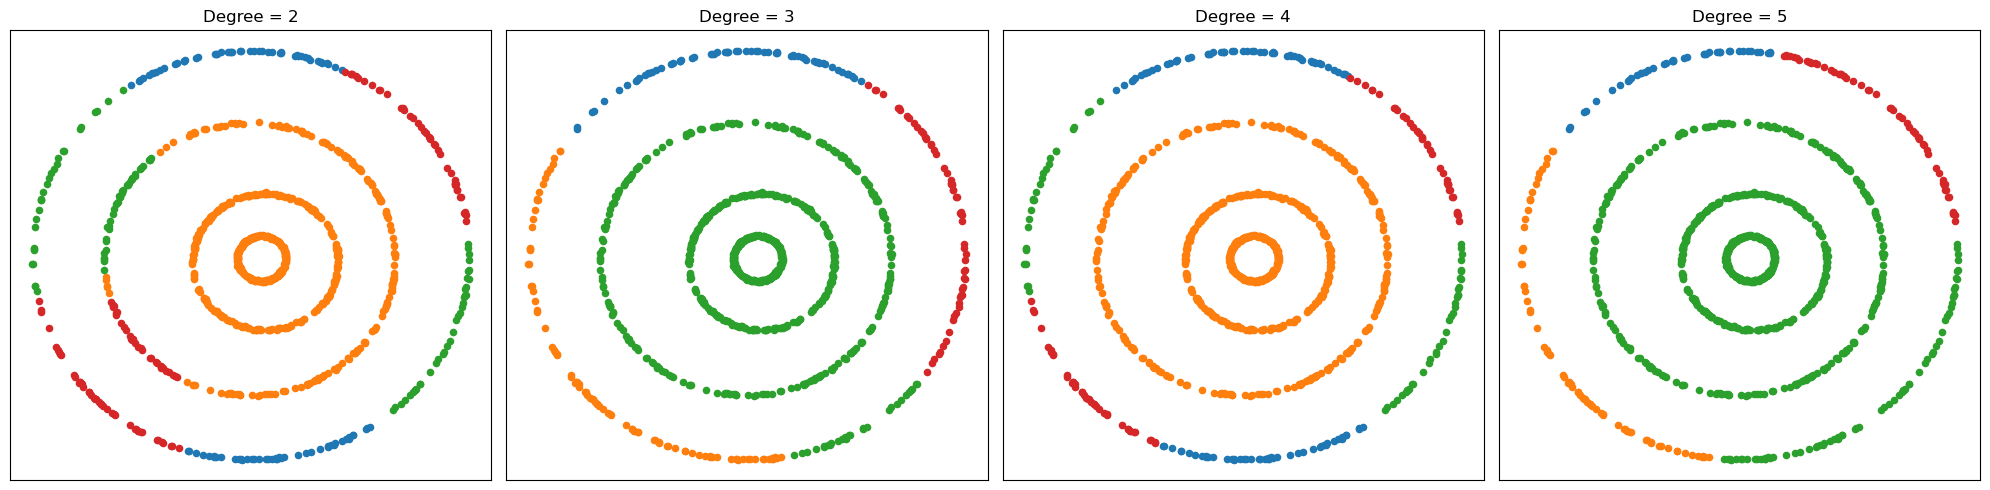

In [38]:
degrees = [2, 3, 4, 5]

fig, axes = plt.subplots(1, len(degrees), figsize=(5*len(degrees), 5))

for idx, d in enumerate(degrees):
    res = polynomial_kernel_from_scratch(points, degree=d, top_k=4)
    U = res['U'].tolist()
    _, labels = kmeans_from_scratch(U, k=4)

    ax = axes[idx]
    colors = plt.cm.tab10.colors
    for j in range(4):
        cluster_pts = [points[i] for i in range(len(points)) if labels[i] == j]
        xs = [p[0] for p in cluster_pts]
        ys = [p[1] for p in cluster_pts]
        ax.scatter(xs, ys, s=20, color=colors[j % len(colors)], label=f"C{j+1}")
    ax.set_title(f"Degree = {d}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.savefig("spectral_poly.png", dpi=300, bbox_inches='tight')
plt.show()


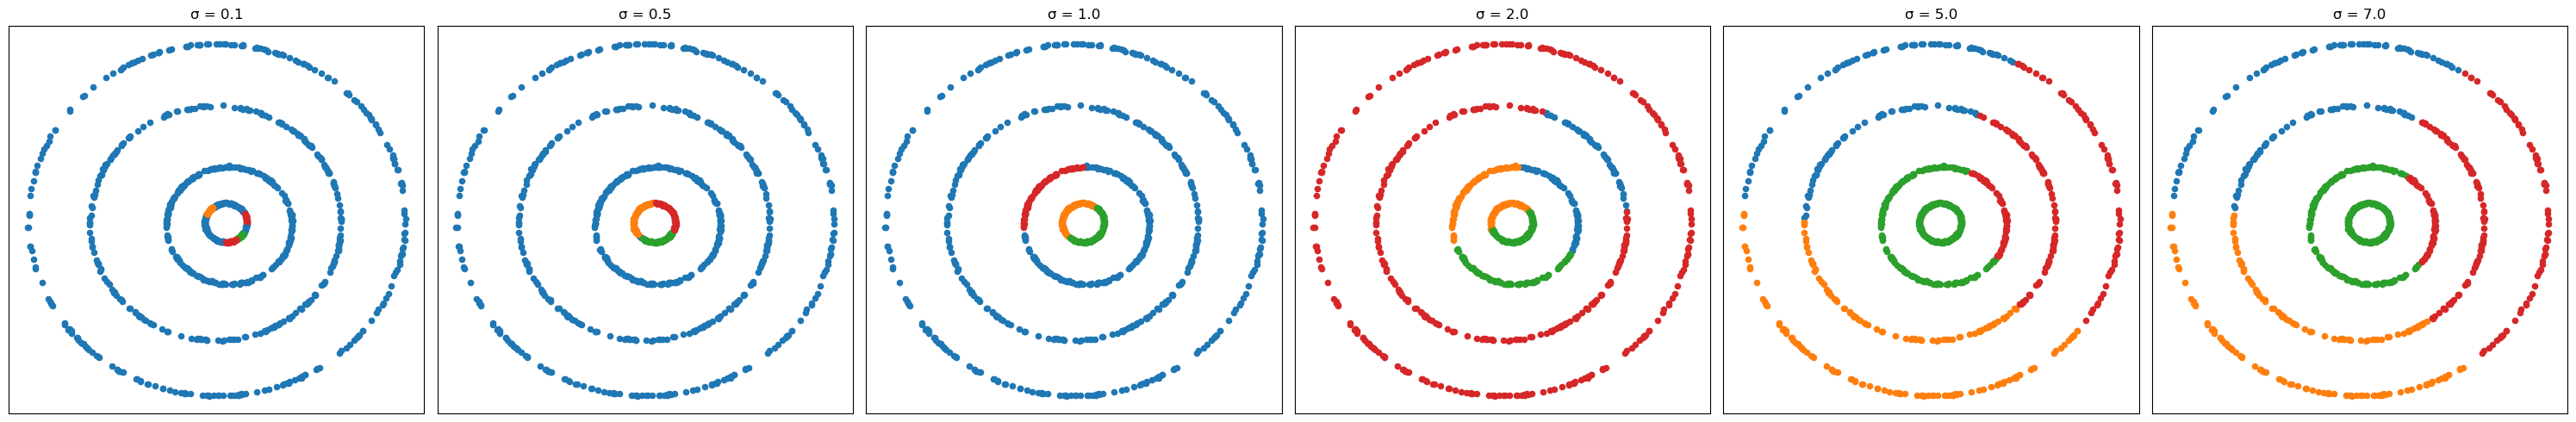

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import math

def rbf_kernel_from_scratch(points, sigma=1.0, top_k=4, eps=1e-12):
    """
    Compute RBF kernel matrix K_ij = exp(-||xi - xj||^2 / (2*sigma^2)) from scratch.
    Center it in feature space, then return top_k eigenvectors/values and embedding U.
    """
    # Convert to list-of-lists for manual loops
    if hasattr(points, "tolist"):
        pts = [list(p) for p in points.tolist()]
    else:
        pts = [list(p) for p in points]

    n = len(pts)
    dim = len(pts[0])

    # --- Step 1: Compute RBF Kernel ---
    K = [[0.0]*n for _ in range(n)]
    for i in range(n):
        xi = pts[i]
        for j in range(i, n):
            xj = pts[j]
            dist_sq = 0.0
            for d in range(dim):
                diff = xi[d] - xj[d]
                dist_sq += diff * diff
            val = math.exp(-dist_sq / (2.0 * sigma * sigma))
            K[i][j] = val
            K[j][i] = val  # symmetry

    # --- Step 2: Center the Kernel ---
    row_sums = [sum(K[i]) for i in range(n)]
    col_sums = [sum(K[j][i] for j in range(n)) for i in range(n)]
    total_sum = sum(row_sums)
    row_means = [rs / n for rs in row_sums]
    col_means = [cs / n for cs in col_sums]
    grand_mean = total_sum / (n*n)

    Kc = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            Kc[i, j] = K[i][j] - row_means[i] - col_means[j] + grand_mean
    Kc = 0.5 * (Kc + Kc.T)  # ensure symmetry

    # --- Step 3: Eigendecomposition ---
    eigvals, eigvecs = np.linalg.eigh(Kc)  # ascending
    idx_desc = np.argsort(eigvals)[::-1]
    eigvals_desc = eigvals[idx_desc]
    eigvecs_desc = eigvecs[:, idx_desc]

    k_take = min(top_k, n)
    top_vals = eigvals_desc[:k_take].copy()
    top_vals = np.where(top_vals < 0, 0.0, top_vals)
    top_vecs = eigvecs_desc[:, :k_take].copy()
    sqrt_vals = np.sqrt(top_vals + eps)
    U = top_vecs * sqrt_vals[np.newaxis, :]

    return {
        'K': K,
        'Kc': Kc,
        'eigvals_desc': eigvals_desc,
        'eigvecs_desc': eigvecs_desc,
        'U': U
    }

# ---------------------- USAGE: Multi-Sigma ----------------------
sigmas = [0.1, 0.5, 1.0, 2.0, 5.0, 7.0]

fig, axes = plt.subplots(1, len(sigmas), figsize=(5*len(sigmas), 5))

for idx, s in enumerate(sigmas):
    res = rbf_kernel_from_scratch(points, sigma=s, top_k=4)
    U = res['U'].tolist()
    _, labels = kmeans_from_scratch(U, k=4)

    ax = axes[idx]
    colors = plt.cm.tab10.colors
    for j in range(4):
        cluster_pts = [points[i] for i in range(len(points)) if labels[i] == j]
        xs = [p[0] for p in cluster_pts]
        ys = [p[1] for p in cluster_pts]
        ax.scatter(xs, ys, s=20, color=colors[j % len(colors)], label=f"C{j+1}")
    ax.set_title(f"σ = {s}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.savefig("spectral_rbf_multi_sigma.png", dpi=300, bbox_inches='tight')
plt.show()


sigma	SSE		eig_gap
7.0	12087.06		1.04308
5.0	12444.90		1.65422
4.0	14742.90		2.03924
3.0	18065.82		2.22865
2.5	28292.99		2.56934
2.0	28841.53		2.95005
1.5	30673.07		1.4109
1.0	30963.63		2.49041
0.5	31438.86		1.09819

Best sigma by SSE: 7.0 SSE= 12087.059226768488


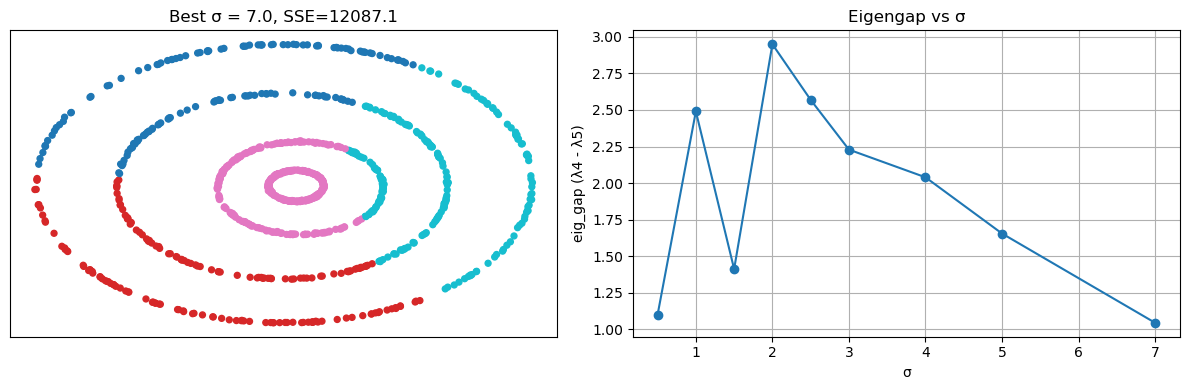

In [19]:
# Sweep sigma, compute SSE and eigengap, pick best sigma
import numpy as np
import matplotlib.pyplot as plt

# replace/ensure these functions exist as from previous code:
# rbf_kernel_from_scratch(points, sigma, top_k=4) -> returns dict with 'U' (numpy array), 'eigvals_desc', etc.
# kmeans_from_scratch(U_list, k=4) -> returns centroids, labels
# sse_in_original_space(X, labels, k) -> computes SSE in original 2D space; if you don't have it, below we define a simple one.

def sse_original(X, labels, k):
    sse = 0.0
    X = list(X)
    for j in range(k):
        pts = [X[i] for i in range(len(X)) if labels[i] == j]
        if len(pts) == 0:
            continue
        # centroid in original space
        cx = sum(p[0] for p in pts) / len(pts)
        cy = sum(p[1] for p in pts) / len(pts)
        for p in pts:
            dx = p[0] - cx
            dy = p[1] - cy
            sse += dx*dx + dy*dy
    return float(sse)

# choose a sigma grid around the region that looked good (2-5)
sigma_grid = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 7.0]

records = []
for s in sigma_grid:
    res = rbf_kernel_from_scratch(points, sigma=s, top_k=4)   # returns dict with 'U' (numpy array) and 'eigvals_desc'
    U = res['U']            # numpy array (n x 4)
    U_list = U.tolist()
    centroids, labels = kmeans_from_scratch(U_list, k=4, max_iters=200, seed=42)
    sse = sse_original(points, labels, 4)
    eigvals = res.get('eigvals_desc', None)
    eig_gap = None
    if eigvals is not None and len(eigvals) > 4:
        # eigvals returned descending; gap between 4th and 5th
        eig_gap = float(eigvals[3] - eigvals[4])
    records.append({'sigma': s, 'sse': sse, 'eig_gap': eig_gap, 'labels': labels, 'eigvals': eigvals})

# print results sorted by sse
records_sorted = sorted(records, key=lambda r: r['sse'])
print("sigma\tSSE\t\teig_gap")
for r in records_sorted:
    print(f"{r['sigma']}\t{r['sse']:.2f}\t\t{(r['eig_gap'] if r['eig_gap'] is not None else 'NA'):.6g}")

best = records_sorted[0]
print("\nBest sigma by SSE:", best['sigma'], "SSE=", best['sse'])

# --- Show best clustering + eigengap in one row ---
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Best clustering scatter
ax = axes[0]
best_labels = best['labels']
ax.scatter([p[0] for p in points], [p[1] for p in points],
           c=best_labels, cmap='tab10', s=18)
ax.set_title(f"Best σ = {best['sigma']}, SSE={best['sse']:.1f}")
ax.set_xticks([]); ax.set_yticks([])

# Eigengap vs sigma line plot
ax = axes[1]
sigmas = [r['sigma'] for r in records]
gaps = [r['eig_gap'] if r['eig_gap'] is not None else 0.0 for r in records]
ax.plot(sigmas, gaps, marker='o')
ax.set_xlabel('σ')
ax.set_ylabel('eig_gap (λ4 - λ5)')
ax.set_title('Eigengap vs σ')
ax.grid(True)

plt.tight_layout()
plt.show()


# Spectral Clustering via Eigenvector Sign / Magnitude

In this final part of the assignment, we explore an alternative way of forming clusters from the eigenvectors of the **kernel (similarity) matrix**.

---

## Step 1: Build Kernel Matrix
We compute the kernel matrix $K$ using either:

- **RBF Kernel**:  
$$K_{ij} = \exp\left(-\frac{\|x_i - x_j\|^2}{2\sigma^2}\right)$$

- **Polynomial Kernel**:  
$$K_{ij} = (x_i^\top x_j + c)^{d}$$

where $\sigma$ is the RBF width, $d$ is the polynomial degree, and $c$ is a constant offset.

---

## Step 2: Center the Kernel
We center the kernel in feature space so that the transformed data has zero mean:

$$K_c = K - \mathbf{1}_n K - K \mathbf{1}_n + \mathbf{1}_n K \mathbf{1}_n$$

where $\mathbf{1}_n = \frac{1}{n}\mathbf{1}\mathbf{1}^\top$.

---

## Step 3: Eigen Decomposition
We compute the eigenvalues and eigenvectors of $K_c$:

$$K_c v_j = \lambda_j v_j$$

We sort the eigenvalues in descending order and take the top-$k$ eigenvectors $(v_1, v_2, \dots, v_k)$.

---

## Step 4: Cluster Assignment via Eigenvectors
Instead of running k-means on the embedding, we directly assign each data point based on the **largest eigenvector component**.

For point $i$:

$$\text{Cluster}(i) = \underset{j \in \{1, \dots, k\}}{\operatorname{argmax}} \; v_j(i)$$

- If we use the **raw values** $v_j(i)$, the signs of eigenvectors may flip, which can swap cluster labels.  
- To stabilize results, we can also use **absolute values**:

$$\text{Cluster}(i) = \underset{j \in \{1, \dots, k\}}{\operatorname{argmax}} \; |v_j(i)|$$

---

## Step 5: Visualization
We compare the two variants:

1. **Raw eigenvectors** → Assign based on the sign and magnitude of eigenvector entries.  
2. **Absolute eigenvectors** → Assign based only on the magnitude, ignoring sign flips.  

Both approaches allow us to map points to clusters directly from the eigenvector space.

---

✅ This method illustrates another perspective of spectral clustering: instead of embedding into $\mathbb{R}^k$ and applying k-means, we can use eigenvectors themselves as direct indicators of cluster membership.


In [20]:
# Part (d): assign point i -> argmax_j v_j(i) (top-k eigenvectors)
# Pure-from-scratch kernel build + centering + eigendecomposition (only np.linalg.eigh).
# Then two assignment variants: raw-eigenvector and abs-eigenvector.

import numpy as np
import math
import matplotlib.pyplot as plt

def rbf_kernel_from_scratch_list(points, sigma):
    """Return K as list-of-lists (pure Python loops)."""
    if hasattr(points, "tolist"):
        pts = [list(p) for p in points.tolist()]
    else:
        pts = [list(p) for p in points]
    n = len(pts)
    d = len(pts[0])
    K = [[0.0]*n for _ in range(n)]
    for i in range(n):
        xi = pts[i]
        for j in range(i, n):
            xj = pts[j]
            dist2 = 0.0
            for t in range(d):
                diff = xi[t] - xj[t]
                dist2 += diff*diff
            val = math.exp(-dist2 / (2.0 * sigma * sigma))
            K[i][j] = val
            K[j][i] = val
    return K

def polynomial_kernel_from_scratch_list(points, degree=3, coef0=1.0):
    """Return polynomial kernel K as list-of-lists."""
    if hasattr(points, "tolist"):
        pts = [list(p) for p in points.tolist()]
    else:
        pts = [list(p) for p in points]
    n = len(pts)
    d = len(pts[0])
    K = [[0.0]*n for _ in range(n)]
    for i in range(n):
        xi = pts[i]
        for j in range(i, n):
            xj = pts[j]
            dot = 0.0
            for t in range(d):
                dot += xi[t] * xj[t]
            val = (dot + coef0)**degree
            K[i][j] = val
            K[j][i] = val
    return K

def center_kernel_list_to_numpy(K_list):
    """Center kernel given as list-of-lists, return centered Kc as numpy array."""
    n = len(K_list)
    # row means
    row_sums = [sum(K_list[i]) for i in range(n)]
    row_means = [rs / n for rs in row_sums]
    # col means
    col_means = [sum(K_list[i][j] for i in range(n)) / n for j in range(n)]
    # grand mean
    grand_mean = sum(row_sums) / (n*n)
    # Kc as numpy
    Kc = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(n):
            Kc[i,j] = K_list[i][j] - row_means[i] - col_means[j] + grand_mean
    # symmetrize numerical noise
    Kc = 0.5 * (Kc + Kc.T)
    return Kc

def assign_by_eigenvectors(Kc, top_k=4, use_abs=False):
    """
    Kc: centered kernel (numpy array)
    top_k: number of largest eigenvectors to use
    use_abs: if True use absolute values |v_{j,i}| when argmax'ing
    Returns labels list length n (values in 0..top_k-1), and eigvals/eigvecs_desc.
    """
    # eigendecomposition (allowed)
    eigvals, eigvecs = np.linalg.eigh(Kc)  # ascending
    # sort descending
    idx = np.argsort(eigvals)[::-1]
    eigvals_desc = eigvals[idx]
    eigvecs_desc = eigvecs[:, idx]  # columns are eigenvectors v_j (j=0 is largest)

    n = Kc.shape[0]
    k_take = min(top_k, n)
    # convert the top_k eigenvectors to a Python-friendly matrix (n x k_take)
    V = eigvecs_desc[:, :k_take]  # numpy array
    # build labels by argmax along eigenvector-dimension for each point i
    labels = [0]*n
    for i in range(n):
        best_j = 0
        best_val = -float('inf')
        for j in range(k_take):
            val = V[i, j]
            if use_abs:
                val = abs(val)
            if val > best_val:
                best_val = val
                best_j = j
        labels[i] = int(best_j)
    return labels, eigvals_desc, V



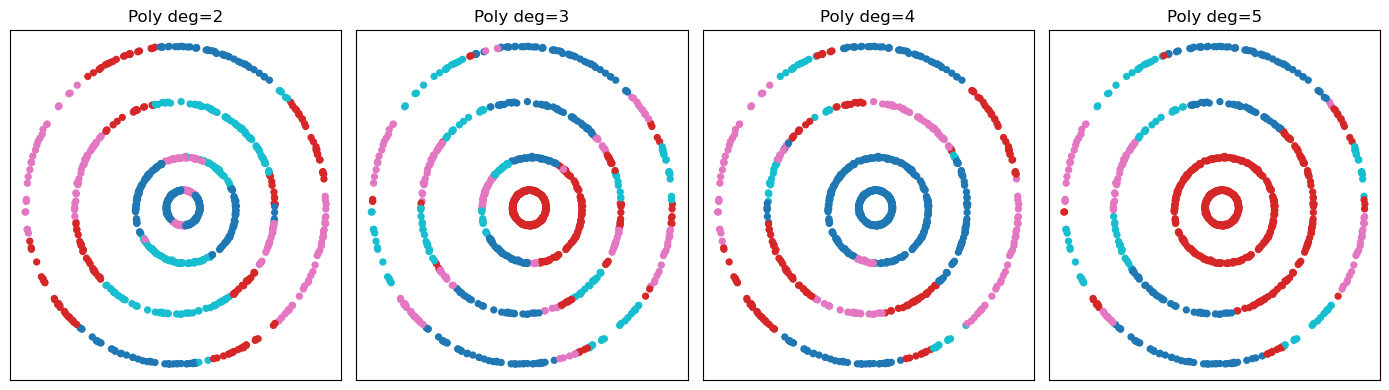

In [21]:
poly_degrees = [2, 3, 4, 5]
fig, axes = plt.subplots(1, len(poly_degrees), figsize=(14,4))

for idx, deg in enumerate(poly_degrees):
    K_list = polynomial_kernel_from_scratch_list(points, degree=deg, coef0=1.0)
    Kc = center_kernel_list_to_numpy(K_list)
    labels, _, _ = assign_by_eigenvectors(Kc, top_k=4, use_abs=True)

    ax = axes[idx]
    ax.scatter([p[0] for p in points], [p[1] for p in points], c=labels, cmap='tab10', s=18)
    ax.set_title(f"Poly deg={deg}")
    ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()


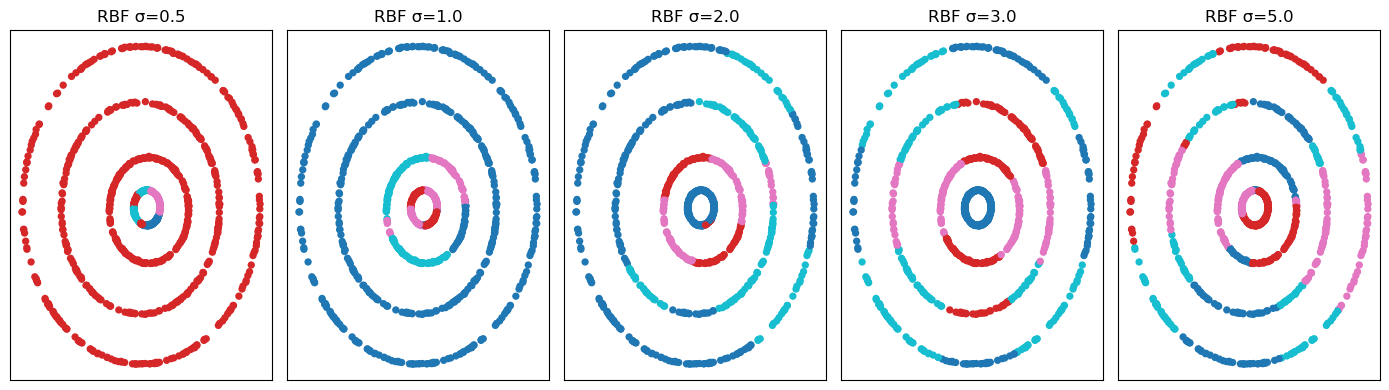

In [22]:
rbf_sigmas = [0.5, 1.0, 2.0, 3.0, 5.0]
fig, axes = plt.subplots(1, len(rbf_sigmas), figsize=(14,4))

for idx, sigma in enumerate(rbf_sigmas):
    K_list = rbf_kernel_from_scratch_list(points, sigma=sigma)
    Kc = center_kernel_list_to_numpy(K_list)
    labels, _, _ = assign_by_eigenvectors(Kc, top_k=4, use_abs=True)

    ax = axes[idx]
    ax.scatter([p[0] for p in points], [p[1] for p in points], c=labels, cmap='tab10', s=18)
    ax.set_title(f"RBF σ={sigma}")
    ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()


## Insights from Eigenvector-based Clustering

In this part, we implemented the clustering rule based on **assigning each point to the cluster corresponding to the eigenvector with the largest (absolute) value component**:

$$
\ell = \arg \max_{j=1,\dots,k} \; |v_{ji}|
$$

where $v_j \in \mathbb{R}^n$ is the eigenvector of the kernel matrix associated with the $j$-th largest eigenvalue.  

---

### Polynomial Kernel Results
- For **low degrees (deg=2,3)**, the clustering fails to properly separate the spiral rings. The eigenvectors do not capture the nonlinear structure well, leading to mixed assignments across clusters.
- For **higher degrees (deg=4,5)**, the separation improves slightly, but the boundaries remain inconsistent. The clusters do not align cleanly with the underlying circular patterns.
- **Conclusion**: Polynomial kernels tend to distort distances in high dimensions, which limits their effectiveness on this dataset.

---

### RBF Kernel Results
- With **small $\sigma$ (e.g., $\sigma=0.5, 1.0$)**, the kernel is too localized, leading to almost all points being collapsed into the same cluster or noisy separations.
- With **moderate $\sigma$ (e.g., $\sigma=2.0, 3.0$)**, the clustering shows better separation across the circular structures, although it is still imperfect.
- With **large $\sigma$ (e.g., $\sigma=5.0$)**, the kernel becomes too smooth, failing to capture local structures, and clusters blend together again.
- **Conclusion**: The RBF kernel performs better than the polynomial kernel, but the chosen mapping rule (based on eigenvector maxima) is still not as effective as standard spectral clustering for producing meaningful cluster assignments.

---

### Overall Observation
This method of assigning clusters based on **eigenvector dominance** does not yield clean clustering on this dataset.  
- It highlights that **kernel choice (Polynomial vs. RBF)** strongly influences results, but  
- More importantly, the **mapping rule itself is limited**, since it ignores the geometric structure captured by combinations of eigenvectors.  
This explains why the method does not produce high-quality clusters in practice.
